In [1]:
import numpy as np
import a4_utils as a4u
import UZ_utils
import matplotlib.pyplot as plt
import cv2
import math
import os
import random


plt.rcParams['figure.figsize'] = [8, 4]

# 1 a

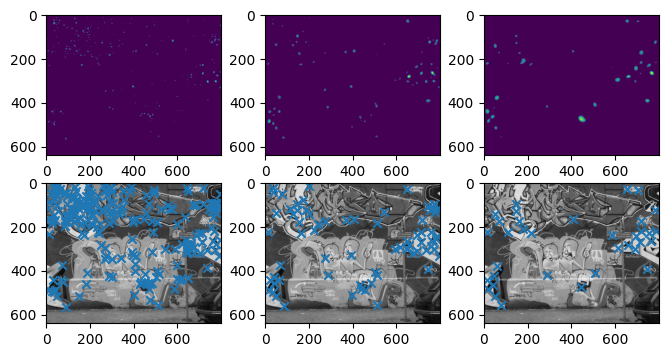

In [2]:
def gaussdx(sigma: float):
    side_width = int(math.ceil(3*sigma))
    kernel_size = int(2 * side_width +1)
    kernel_x_values = np.array(range(-side_width, side_width+1))
    coef = -1 / ((sigma ** 3) * math.sqrt(2*math.pi))
    kernel =  coef * kernel_x_values * np.exp( -(kernel_x_values ** 2) / (2* (sigma**2)) )
    
    kernel_abs = np.abs(kernel)
    kernel /= np.sum(kernel_abs)
    return kernel, kernel_x_values

def gauss(sigma: float):
    side_width = int(math.ceil(3*sigma))
    kernel_size = int(2 * side_width +1)
    kernel_x_values = np.array(range(-side_width, side_width+1))
    coef = 1 / (sigma * math.sqrt(2*math.pi))
    kernel =  coef * np.exp( -(kernel_x_values ** 2) / (2* (sigma**2)) )
    kernel /= np.sum(kernel)
    return kernel, kernel_x_values

def gauss_kern_horizontal_faux2D(sigma: float):
    ker = gauss(sigma)[0].reshape(1, -1)
    return ker

def gaussdx_kern_horizontal_faux2D(sigma: float):
    ker = gaussdx(sigma)[0].reshape(1, -1)
    return ker

def image_partial_derivatives(image, sigma: float):
    x_gauss = gauss_kern_horizontal_faux2D(sigma)
    y_gauss = x_gauss.T
    x_gauss_der = gaussdx_kern_horizontal_faux2D(sigma)
    y_gauss_der = x_gauss_der.T

    x_partial = UZ_utils.convolve(image, y_gauss, x_gauss_der)
    y_partial = UZ_utils.convolve(image, x_gauss, y_gauss_der)
    return x_partial, y_partial

def image_second_partial_ders(image, sigma: float):
    x_partial, y_partial = image_partial_derivatives(image, sigma)
    
    x_second_partial, xy_second_partial = image_partial_derivatives(x_partial, sigma)
    _, y_second_partial = image_partial_derivatives(y_partial, sigma)

    return x_second_partial, xy_second_partial, y_second_partial

def hessian_feature_points(image, sigma, t, neigh_one_side_size):
    """
    dx_kernel = -np.ones((1, 2))
    dx_kernel[0,0] = 1
    print("dx_kernel")
    print(dx_kernel)

    dy_kernel = -np.ones((2, 1))
    dy_kernel[0,0] = 1
    print("dy_kernel")
    print(dy_kernel)


    gauss_1dim = a4u.gauss(sigma)
    gauss_2dim = gauss_1dim.T * gauss_1dim
    print("gauss_2dim")
    print(gauss_2dim)
    print("gauss_2dim.sum()")
    print(gauss_2dim.sum())
    UZ_utils.imshow(gauss_2dim)


    graf_gauss = a4u.convolve(image, gauss_2dim)

    graf_gauss = graf_gauss / graf_gauss.max()

    graf_dx = a4u.convolve(graf_gauss, dx_kernel)
    graf_dy = a4u.convolve(graf_gauss, dy_kernel)

    graf_xx = a4u.convolve(graf_dx, dx_kernel)
    graf_xy = a4u.convolve(graf_dx, dy_kernel)
    graf_yy = a4u.convolve(graf_dy, dy_kernel)
    """

    graf_xx, graf_xy, graf_yy = image_second_partial_ders(image, sigma)
    graf_hessian_det = graf_xx * graf_yy - graf_xy * graf_xy
    # print("graf_hessian_det.shape")
    # print(graf_hessian_det.shape)
    # print("graf_hessian_det.max()")
    # print(graf_hessian_det.max())
    # print("graf_hessian_det")
    # print(graf_hessian_det)
    graf_feature_points = graf_hessian_det * (graf_hessian_det > t)
    # print("image")
    # print(graf_feature_points)

    return graf_feature_points

    


def nonmaxima_surpress(image, neigh_one_side_size):
    image_non_maxima = np.zeros(image.shape)

    for y_ix in range(image.shape[0]):
        for x_ix in range(image.shape[1]):
            y_bot = y_ix - neigh_one_side_size
            y_top = y_ix + neigh_one_side_size
            x_left = x_ix - neigh_one_side_size
            x_right = x_ix + neigh_one_side_size

            if y_bot < 0:
                y_bot = 0
            if y_top > image.shape[0] - 1:
                y_top = image.shape[0] - 1
            
            if x_left < 0:
                x_left = 0
            if x_right > image.shape[1] - 1:
                x_right = image.shape[1] - 1

            neigh_max = image[y_bot:y_top, x_left:x_right].max()
            if image[y_ix, x_ix] == neigh_max:
                image_non_maxima[y_ix, x_ix] = image[y_ix, x_ix]
            

    return image_non_maxima









g_sigmas = [3, 6, 9]
g_t = 0.004
g_neigh_one_side = 7


graf_a = UZ_utils.imread_gray(".\data\graf\graf_a.jpg")


for i, curr_sigma in enumerate(g_sigmas):
    # print("i, curr_sigma")
    # print(i, curr_sigma)


    # print("graf_a.shape")
    # print(graf_a.shape)
    feature_points = hessian_feature_points(graf_a, curr_sigma, g_t, g_neigh_one_side)

    # print(feature_points)
    plt.subplot(2, 3, 1 + i)
    plt.imshow(feature_points)
    
    fp_non_maxima = nonmaxima_surpress(feature_points, g_neigh_one_side)
    fp_image_ix_pairs = np.nonzero(fp_non_maxima)

    plt.subplot(2, 3, 4 + i)
    plt.imshow(graf_a, cmap="gray")
    plt.scatter(fp_image_ix_pairs[1], fp_image_ix_pairs[0], marker="x")

plt.show()






# 1 b

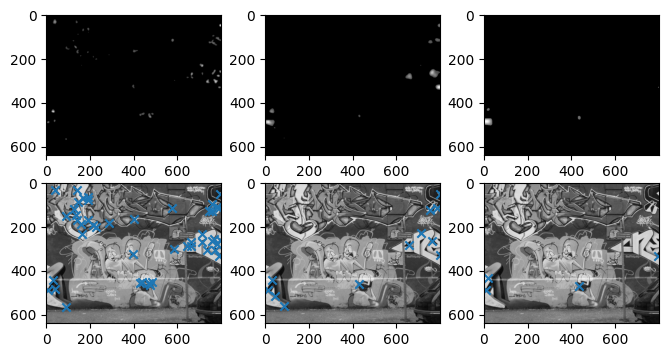

In [13]:

def harris_feature_points(image, sigma, smoothing_sigma, alpha, tresh, neigh_one_side_size):
    x_partial, y_partial = image_partial_derivatives(image, sigma)

    x_partial_squared = x_partial * x_partial
    x_partial_times_y_partial = x_partial * y_partial
    y_partial_squared = y_partial * y_partial

    gauss_1dim = a4u.gauss(smoothing_sigma)
    gauss_2dim = gauss_1dim.T * gauss_1dim
    # print("gauss_2dim")
    # print(gauss_2dim)
    # print("gauss_2dim.sum()")
    # print(gauss_2dim.sum())
    # UZ_utils.imshow(gauss_2dim)

    x_partial_squared_smoothed = a4u.convolve(x_partial_squared, gauss_2dim)
    x_partial_times_y_partial_smoothed = a4u.convolve(x_partial_times_y_partial, gauss_2dim)
    y_partial_squared_smoothed = a4u.convolve(y_partial_squared, gauss_2dim)

    determinant = x_partial_squared_smoothed * y_partial_squared_smoothed - x_partial_times_y_partial_smoothed * x_partial_times_y_partial_smoothed
    trace_squared = (x_partial_squared_smoothed + y_partial_squared_smoothed) * (x_partial_squared_smoothed + y_partial_squared_smoothed)

    combined_result = determinant - alpha * trace_squared




    graf_feature_points = combined_result * (combined_result > tresh)

    return graf_feature_points

    


g_sigmas = [3, 6, 9]
g_smoothing_sigma = [1.6 * i for i in g_sigmas]
g_t = 1e-4
g_alpha = 0.06
g_neigh_one_side = 5


graf_a = UZ_utils.imread_gray(".\data\graf\graf_a.jpg")


for i, curr_sigma in enumerate(g_sigmas):
    # print("i, curr_sigma")
    # print(i, curr_sigma)


    # print("graf_a.shape")
    # print(graf_a.shape)
    feature_points = harris_feature_points(graf_a, curr_sigma, g_smoothing_sigma[i], g_alpha, g_t, g_neigh_one_side)

    fp_non_maxima = nonmaxima_surpress(feature_points, g_neigh_one_side)
    fp_image_ix_pairs = np.nonzero(fp_non_maxima)


    # print(feature_points)
    plt.subplot(2, 3, 1 + i)
    plt.imshow(feature_points)
    
    fp_non_maxima = nonmaxima_surpress(feature_points, g_neigh_one_side)
    fp_image_ix_pairs = np.nonzero(fp_non_maxima)

    plt.subplot(2, 3, 4 + i)
    plt.imshow(graf_a, cmap="gray")
    plt.scatter(fp_image_ix_pairs[1], fp_image_ix_pairs[0], marker="x")

plt.show()



    

# 2 a

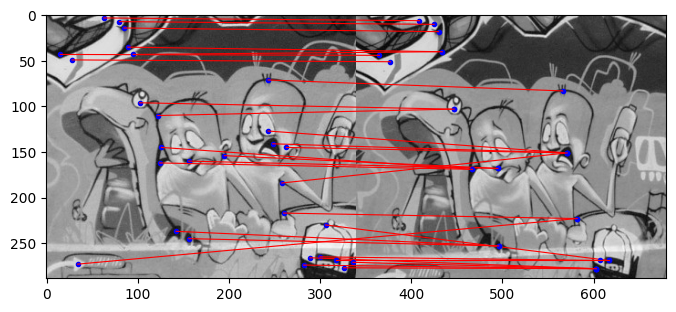

In [4]:
def hellinger_distance(hist1, hist2):
    hist_root_diff = hist1 ** (1/2) - hist2 ** (1/2)
    hist_dist = (1/2 * np.sum(hist_root_diff ** 2)) ** (1/2)
    return hist_dist

def find_correspondances(features_a, features_b):
    """
    features_a is a list of lists.
    Its 0th element is a list of descriptors for the 0th feature point.

    Returns 2 arrays.
    The 0th elem of the first array contains the ix from features_b, that was
    the best corresponding point to the 0th element of features_a.

    The second returning array is vice versa.
    """
    features_a_best_matches = np.zeros(features_a.shape[0])
    features_b_best_matches = np.zeros(features_b.shape[0])

    for a_ix in range(features_a.shape[0]):
        b_ix_current_best = -1
        dist_current_best = float('inf')

        for b_ix in range(features_b.shape[0]):
            dist_current = hellinger_distance(features_a[a_ix], features_b[b_ix])
            if dist_current < dist_current_best:
                dist_current_best = dist_current
                b_ix_current_best = b_ix
        
        features_a_best_matches[a_ix] = b_ix_current_best
    

    for b_ix in range(features_b.shape[0]):
        a_ix_current_best = -1
        dist_current_best = float('inf')

        for a_ix in range(features_a.shape[0]):
            dist_current = hellinger_distance(features_b[b_ix], features_a[a_ix])
            if dist_current < dist_current_best:
                dist_current_best = dist_current
                a_ix_current_best = a_ix
        
        features_b_best_matches[b_ix] = a_ix_current_best

    
    features_a_best_matches = features_a_best_matches.astype('int')
    features_b_best_matches = features_b_best_matches.astype('int')

    return features_a_best_matches, features_b_best_matches




g_sigma = 3
g_t_hessian = 0.004
g_non_max_neigh = 3

g_t_harris = 1e-6
g_smoothing_sigma = 1.6 * g_sigma
g_alpha = 0.06

g_n_bins = 16

graf_a = UZ_utils.imread_gray(".\data\graf\graf_a_small.jpg")
graf_b = UZ_utils.imread_gray(".\data\graf\graf_b_small.jpg")


def simple_desc_harris(image, sigma, smoothing_sigma, alpha, tresh, non_max_neigh, n_bins):
    """
    Returns: fp_image_ix_pairs, simple_descs
    """
    
    fp_image = harris_feature_points(image, sigma, smoothing_sigma, alpha,  tresh, non_max_neigh)
    
    fp_non_maxima = nonmaxima_surpress(fp_image, non_max_neigh)
    fp_image_ix_pairs = np.nonzero(fp_non_maxima)

    simple_descs = a4u.simple_descriptors(image, fp_image_ix_pairs[0], fp_image_ix_pairs[1], n_bins)
    # print(simple_descriptors)

    return fp_image_ix_pairs, simple_descs


def simple_desc_hessian(image, sigma, tresh, non_max_neigh, n_bins):
    """
    Returns: fp_image_ix_pairs, simple_descs
    """
    
    fp_image = hessian_feature_points(image, sigma, tresh, non_max_neigh)

    fp_non_maxima = nonmaxima_surpress(fp_image, non_max_neigh)
    fp_image_ix_pairs = np.nonzero(fp_non_maxima)

    simple_descs = a4u.simple_descriptors(image, fp_image_ix_pairs[0], fp_image_ix_pairs[1], n_bins)
    # print(simple_descriptors)

    return fp_image_ix_pairs, simple_descs



fp_image_ixs_a, simple_descs_a = simple_desc_hessian(graf_a, g_sigma, g_t_hessian, g_non_max_neigh, g_n_bins)
fp_image_ixs_b, simple_descs_b = simple_desc_hessian(graf_b, g_sigma, g_t_hessian, g_non_max_neigh, g_n_bins)

# these are the indexes of the other best matches, They point to their most corresponding point.
fp_a_best_matches, fp_b_best_matches = find_correspondances(simple_descs_a, simple_descs_b)

# print("fp_a_best_matches")
# print(fp_a_best_matches)

# print("fp_image_ixs_b")
# print(fp_image_ixs_b)

# Now we make Nx2 vectors, left column being the x coordinate. The a4u function asks for this.
fp_a_match_image_ixs = np.zeros((fp_a_best_matches.size, 2))
for i in range(fp_a_best_matches.size):
    ix = fp_a_best_matches[i]

    fp_a_match_image_ixs[i, 0] = fp_image_ixs_b[1][ix]
    fp_a_match_image_ixs[i, 1] = fp_image_ixs_b[0][ix]


fp_image_ixs_a_for_display = np.zeros((fp_image_ixs_a[0].size, 2))
for i in range(fp_image_ixs_a[0].size):
    fp_image_ixs_a_for_display[i, 0] = fp_image_ixs_a[1][i]
    fp_image_ixs_a_for_display[i, 1] = fp_image_ixs_a[0][i]


a4u.display_matches(graf_a, fp_image_ixs_a_for_display, graf_b, fp_a_match_image_ixs)








# Doing it for harris also:

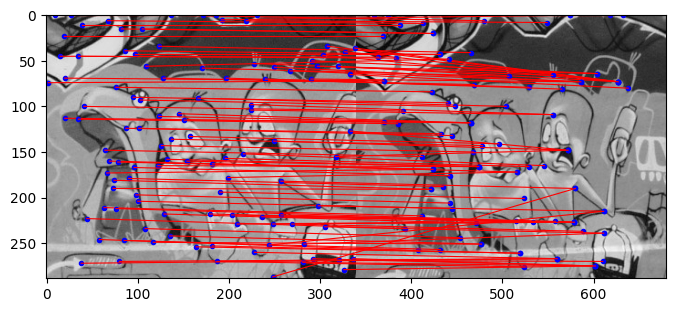

In [5]:
fp_image_ixs_a, simple_descs_a = simple_desc_harris(graf_a, g_sigma, g_smoothing_sigma, g_alpha, g_t_harris, g_non_max_neigh, g_n_bins)
fp_image_ixs_b, simple_descs_b = simple_desc_harris(graf_b, g_sigma, g_smoothing_sigma, g_alpha, g_t_harris, g_non_max_neigh, g_n_bins)

# these are the indexes of the other best matches, They point to their most corresponding point.
fp_a_best_matches, fp_b_best_matches = find_correspondances(simple_descs_a, simple_descs_b)

# print("fp_a_best_matches")
# print(fp_a_best_matches)

# print("fp_image_ixs_b")
# print(fp_image_ixs_b)

# Now we make Nx2 vectors, left column being the x coordinate. The a4u function asks for this.
fp_a_match_image_ixs = np.zeros((fp_a_best_matches.size, 2))
for i in range(fp_a_best_matches.size):
    ix = fp_a_best_matches[i]

    fp_a_match_image_ixs[i, 0] = fp_image_ixs_b[1][ix]
    fp_a_match_image_ixs[i, 1] = fp_image_ixs_b[0][ix]


fp_image_ixs_a_for_display = np.zeros((fp_image_ixs_a[0].size, 2))
for i in range(fp_image_ixs_a[0].size):
    fp_image_ixs_a_for_display[i, 0] = fp_image_ixs_a[1][i]
    fp_image_ixs_a_for_display[i, 1] = fp_image_ixs_a[0][i]


a4u.display_matches(graf_a, fp_image_ixs_a_for_display, graf_b, fp_a_match_image_ixs)

# 2 b

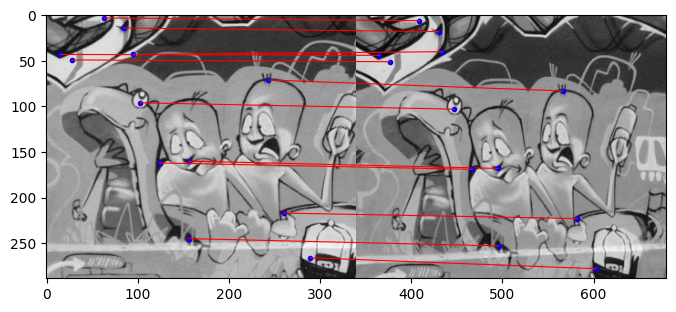

In [6]:

def find_matches_hessian(image_a, image_b):
    sigma = 3
    t = 0.004
    
    non_max_neigh = 7


    n_bins = 16

    fp_image_ixs_a, simple_descs_a = simple_desc_hessian(image_a, sigma, t, non_max_neigh, n_bins)
    fp_image_ixs_b, simple_descs_b = simple_desc_hessian(image_b, sigma, t, non_max_neigh, n_bins)

    fp_image_ixs_a = list(zip(fp_image_ixs_a[0], fp_image_ixs_a[1]))
    fp_image_ixs_b = list(zip(fp_image_ixs_b[0], fp_image_ixs_b[1]))

    # these are the indexes of the other best matches, They point to their most corresponding point.
    fp_a_best_matches, fp_b_best_matches = find_correspondances(simple_descs_a, simple_descs_b)

    fp_symetric_matches = []

    for a_ix in range(fp_a_best_matches.size):
        matched_b_ix = fp_a_best_matches[a_ix]
        matches_match = fp_b_best_matches[matched_b_ix]

        if a_ix == matches_match:
            fp_symetric_matches.append((fp_image_ixs_a[a_ix], fp_image_ixs_b[matched_b_ix]))

    return fp_symetric_matches





graf_a = UZ_utils.imread_gray(".\data\graf\graf_a_small.jpg")
graf_b = UZ_utils.imread_gray(".\data\graf\graf_b_small.jpg")

matched_pairs_of_ixs = find_matches_hessian(graf_a, graf_b)

graf_a_array_for_display = np.zeros((len(matched_pairs_of_ixs), 2))
graf_b_array_for_display = np.zeros((len(matched_pairs_of_ixs), 2))

for i in range(len(matched_pairs_of_ixs)):
    graf_a_array_for_display[i, 0] = matched_pairs_of_ixs[i][0][1]
    graf_a_array_for_display[i, 1] = matched_pairs_of_ixs[i][0][0]
    graf_b_array_for_display[i, 0] = matched_pairs_of_ixs[i][1][1]
    graf_b_array_for_display[i, 1] = matched_pairs_of_ixs[i][1][0]


a4u.display_matches(graf_a, graf_a_array_for_display, graf_b, graf_b_array_for_display)




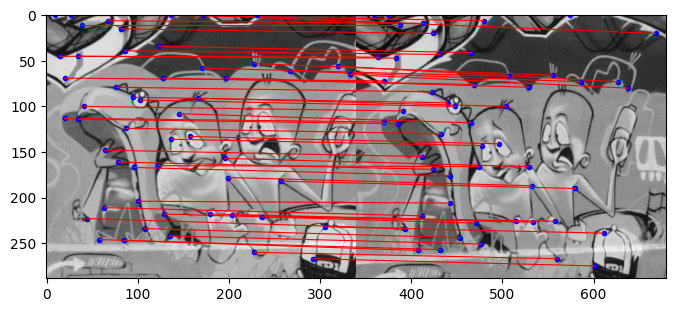

In [7]:
def find_matches_harris(image_a, image_b):
    sigma = 3
    smoothing_sigma = 1.6 * sigma
    t = 1e-6
    
    
    alpha = 0.06
    non_max_neigh = 7


    n_bins = 16

    fp_image_ixs_a, simple_descs_a = simple_desc_harris(image_a, sigma, smoothing_sigma, alpha, t, non_max_neigh, n_bins)
    fp_image_ixs_b, simple_descs_b = simple_desc_harris(image_b, sigma, smoothing_sigma, alpha, t, non_max_neigh, n_bins)

    fp_image_ixs_a = list(zip(fp_image_ixs_a[0], fp_image_ixs_a[1]))
    fp_image_ixs_b = list(zip(fp_image_ixs_b[0], fp_image_ixs_b[1]))

    # these are the indexes of the other best matches, They point to their most corresponding point.
    fp_a_best_matches, fp_b_best_matches = find_correspondances(simple_descs_a, simple_descs_b)

    fp_symetric_matches = []

    for a_ix in range(fp_a_best_matches.size):
        matched_b_ix = fp_a_best_matches[a_ix]
        matches_match = fp_b_best_matches[matched_b_ix]

        if a_ix == matches_match:
            fp_symetric_matches.append((fp_image_ixs_a[a_ix], fp_image_ixs_b[matched_b_ix]))

    return fp_symetric_matches





graf_a = UZ_utils.imread_gray(".\data\graf\graf_a_small.jpg")
graf_b = UZ_utils.imread_gray(".\data\graf\graf_b_small.jpg")

matched_pairs_of_ixs = find_matches_harris(graf_a, graf_b)

graf_a_array_for_display = np.zeros((len(matched_pairs_of_ixs), 2))
graf_b_array_for_display = np.zeros((len(matched_pairs_of_ixs), 2))

for i in range(len(matched_pairs_of_ixs)):
    graf_a_array_for_display[i, 0] = matched_pairs_of_ixs[i][0][1]
    graf_a_array_for_display[i, 1] = matched_pairs_of_ixs[i][0][0]
    graf_b_array_for_display[i, 0] = matched_pairs_of_ixs[i][1][1]
    graf_b_array_for_display[i, 1] = matched_pairs_of_ixs[i][1][0]


a4u.display_matches(graf_a, graf_a_array_for_display, graf_b, graf_b_array_for_display)



# 3 a

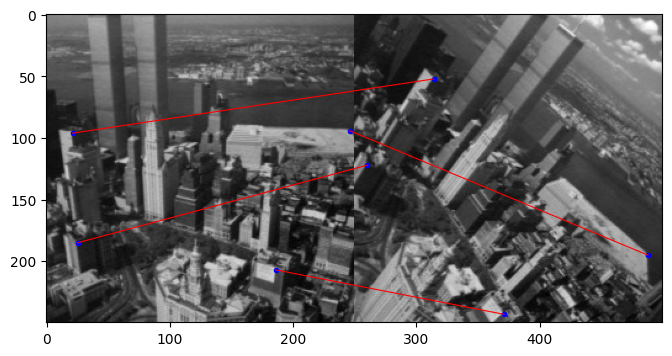

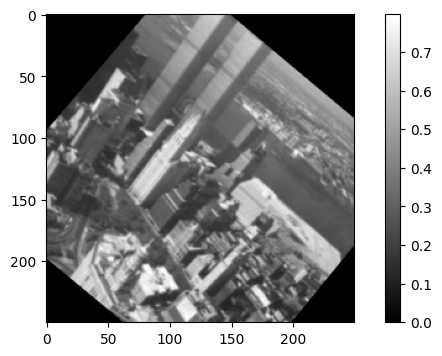

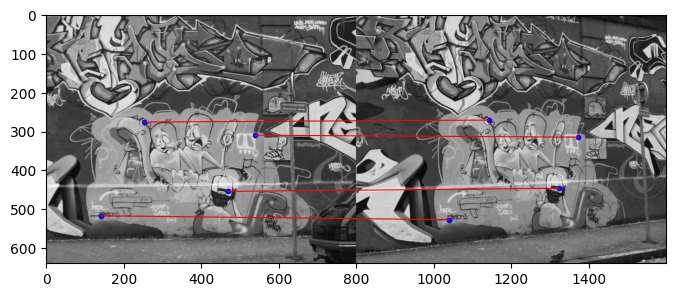

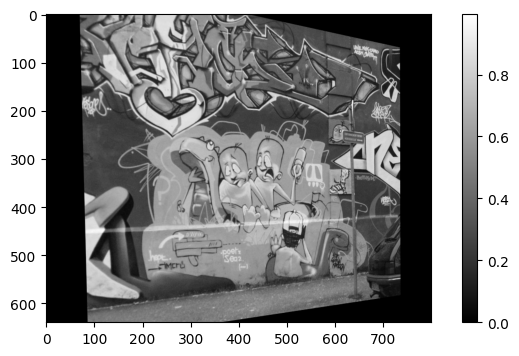

In [8]:

def estimate_homography(correspondences):

    xr = correspondences[:,0]
    yr = correspondences[:,1]
    xt = correspondences[:,2]
    yt = correspondences[:,3]


    A = np.zeros((correspondences.shape[0] * 2, 9))

    for i in range(correspondences.shape[0]):
        ix = i * 2
        A[ix, 0] = xr[i]
        A[ix, 1] = yr[i]
        A[ix, 2] = 1
        A[ix, 6] = -xt[i]* xr[i]
        A[ix, 7] = -xt[i]* yr[i]
        A[ix, 8] = -xt[i]
    
    for i in range(correspondences.shape[0]):
        ix = i * 2 + 1
        A[ix, 3] = xr[i]
        A[ix, 4] = yr[i]
        A[ix, 5] = 1
        A[ix, 6] = -yt[i]* xr[i]
        A[ix, 7] = -yt[i]* yr[i]
        A[ix, 8] = -yt[i]
    

    U, S, VT = np.linalg.svd(A)
    V = VT.T

    h = V[:, -1] / V[-1, -1]

    H = h.reshape(3,3)
    # print(H)

    return H







I_a = UZ_utils.imread_gray(".\data\\newyork\\newyork_a.jpg")
I_b = UZ_utils.imread_gray(".\data\\newyork\\newyork_b.jpg")
correspondences = np.loadtxt(".\data\\newyork\\newyork.txt")
# print(correspondences)

H = estimate_homography(correspondences)

pts1 = np.column_stack((correspondences[:,0], correspondences[:,1]))
# print(pts1)
pts2 = np.column_stack((correspondences[:,2], correspondences[:,3]))
# print(pts2)

a4u.display_matches(I_a, pts1, I_b, pts2)

I_a_warped = cv2.warpPerspective(I_a, H, I_a.shape[::-1])
UZ_utils.imshow(I_a_warped)







I_a = UZ_utils.imread_gray(".\data\graf\graf_a.jpg")
I_b = UZ_utils.imread_gray(".\data\graf\graf_b.jpg")
correspondences = np.loadtxt(".\data\graf\graf.txt")
# print(correspondences)

H = estimate_homography(correspondences)

pts1 = np.column_stack((correspondences[:,0], correspondences[:,1]))
# print(pts1)
pts2 = np.column_stack((correspondences[:,2], correspondences[:,3]))
# print(pts2)

a4u.display_matches(I_a, pts1, I_b, pts2)

I_a_warped = cv2.warpPerspective(I_a, H, I_a.shape[::-1])

UZ_utils.imshow(I_a_warped)







# How does find_points work on new york?

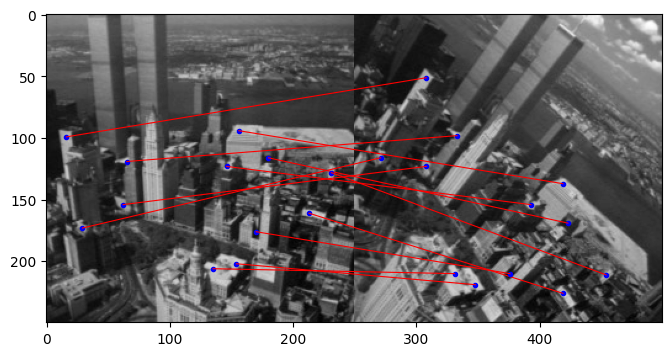

In [9]:
graf_a = UZ_utils.imread_gray(".\data\\newyork\\newyork_a.jpg")
graf_b = UZ_utils.imread_gray(".\data\\newyork\\newyork_b.jpg")

matched_pairs_of_ixs = find_matches_hessian(graf_a, graf_b)

graf_a_array_for_display = np.zeros((len(matched_pairs_of_ixs), 2))
graf_b_array_for_display = np.zeros((len(matched_pairs_of_ixs), 2))

for i in range(len(matched_pairs_of_ixs)):
    graf_a_array_for_display[i, 0] = matched_pairs_of_ixs[i][0][1]
    graf_a_array_for_display[i, 1] = matched_pairs_of_ixs[i][0][0]
    graf_b_array_for_display[i, 0] = matched_pairs_of_ixs[i][1][1]
    graf_b_array_for_display[i, 1] = matched_pairs_of_ixs[i][1][0]


a4u.display_matches(graf_a, graf_a_array_for_display, graf_b, graf_b_array_for_display)

## Works awesome, so why does ransac destroy it?

# 3 b

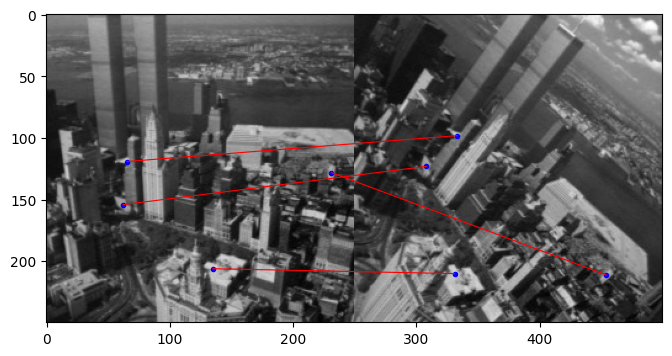

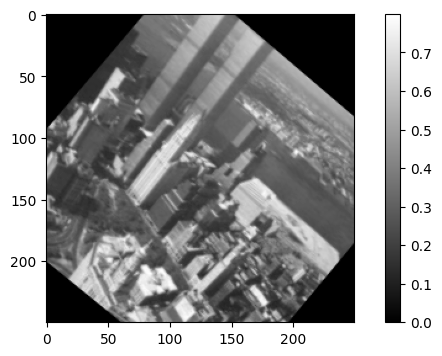

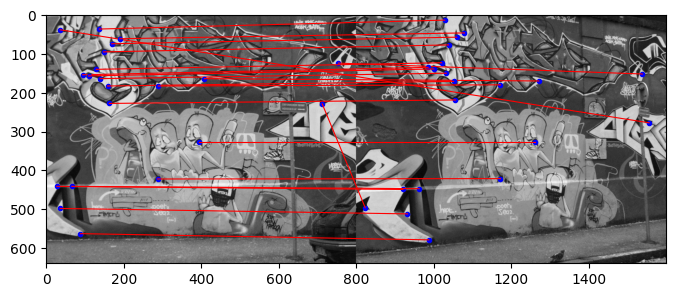

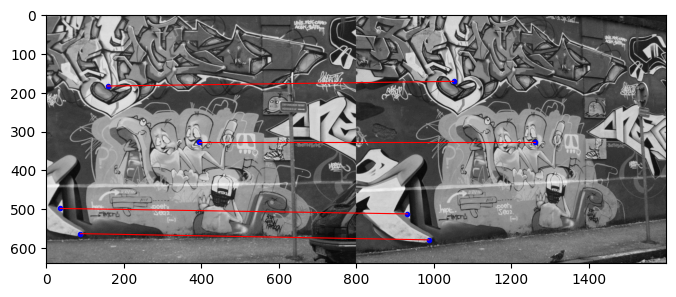

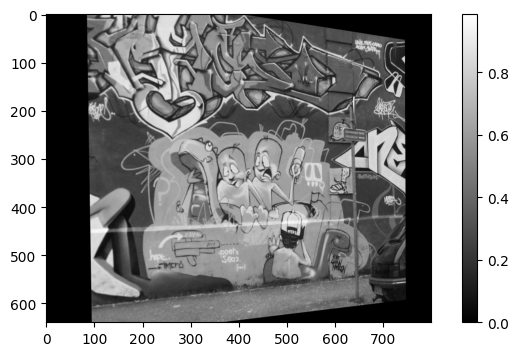

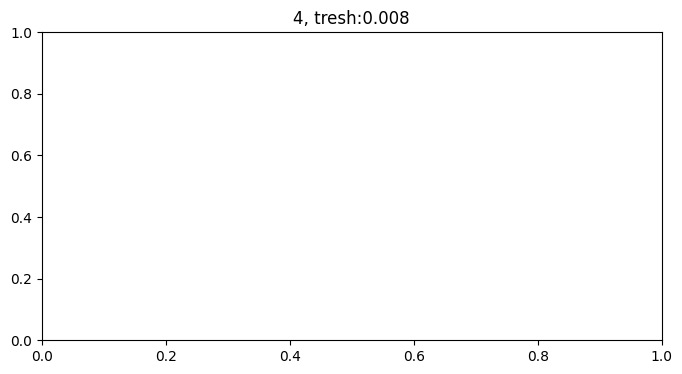

In [26]:



def reprojection_error(H, coresps):

    # pts_a_x = coresps[:, 0]
    # pts_a_y = coresps[:, 1]
    # pts_b_x = coresps[:, 2]
    # pts_b_y = coresps[:, 3]

    pts_a_x = np.array([matched_points[i][0][1] for i in range(len(matched_points))])
    pts_a_y = np.array([matched_points[i][0][0] for i in range(len(matched_points))])
    pts_b_x = np.array([matched_points[i][1][1] for i in range(len(matched_points))])
    pts_b_y = np.array([matched_points[i][1][0] for i in range(len(matched_points))])

    distance = 0

    for i in range(len(pts_a_x)):
        pt_a = np.array([pts_a_x[i], pts_a_y[i], 1]).reshape((3,1))
        new_pt = np.matmul(H, pt_a)
        new_pt = new_pt[:2] / new_pt[2]

        pt_b = np.array([pts_b_x[i], pts_b_y[i]]).reshape((2,1))
        diff_vec = pt_b - new_pt
        diff = np.sqrt(np.sum(diff_vec ** 2))

        distance += diff
    
    return (distance / len(pts_a_x))

def ransac(matched_points, num_of_iters):
    # print(matched_points)
    pts_a_x = np.array([matched_points[i][0][1] for i in range(len(matched_points))]).reshape(-1, 1)
    pts_a_y = np.array([matched_points[i][0][0] for i in range(len(matched_points))]).reshape(-1, 1)
    pts_b_x = np.array([matched_points[i][1][1] for i in range(len(matched_points))]).reshape(-1, 1)
    pts_b_y = np.array([matched_points[i][1][0] for i in range(len(matched_points))]).reshape(-1, 1)

    smallest_err = float('inf')
    best_H = []
    best_corresps = []


    for i in range(num_of_iters):

        chosen_four = random.sample(range(len(matched_points)), k=4)

        # print(pts_a_x)
        # print(chosen_four)
        # print(pts_a_x[chosen_four])
        
        corresps = np.column_stack((pts_a_x[chosen_four], pts_a_y[chosen_four], pts_b_x[chosen_four], pts_b_y[chosen_four]))
        # print(corresps)

        H = estimate_homography(corresps)
        # print(H)

        rep_err = reprojection_error(H, matched_points)

        if rep_err < smallest_err:
            smallest_err = rep_err
            best_H = H
            best_corresps = corresps
    
    return best_corresps, best_H




    
I_a = UZ_utils.imread_gray(".\data\\newyork\\newyork_a.jpg")
I_b = UZ_utils.imread_gray(".\data\\newyork\\newyork_b.jpg")


matched_points = find_matches_hessian(I_a, I_b)
    
coresps, H = ransac(matched_points, num_of_iters=100)


pts1 = np.column_stack((coresps[:,0], coresps[:,1]))
# print(pts1)
pts2 = np.column_stack((coresps[:,2], coresps[:,3]))
# print(pts2)

a4u.display_matches(I_a, pts1, I_b, pts2)

I_a_warped = cv2.warpPerspective(I_a, H, I_a.shape[::-1])
UZ_utils.imshow(I_a_warped)

plt.show()






# I_a = UZ_utils.imread_gray(".\data\graf\graf_a.jpg")
# I_b = UZ_utils.imread_gray(".\data\graf\graf_b.jpg")


# matched_points = find_matches_hessian(I_a, I_b)
# print(matched_points)
    
# coresps, H = ransac(matched_points, num_of_iters=2000)


# pts1 = np.column_stack((coresps[:,0], coresps[:,1]))
# # print(pts1)
# pts2 = np.column_stack((coresps[:,2], coresps[:,3]))
# # print(pts2)

# a4u.display_matches(I_a, pts1, I_b, pts2)

# I_a_warped = cv2.warpPerspective(I_a, H, I_a.shape[::-1])
# UZ_utils.imshow(I_a_warped)

# plt.show()














def find_matches_hessian_parameter_set(image_a, image_b, sigma=3, t=0.004, non_max_neigh=7, n_bins=16):
    

    fp_image_ixs_a, simple_descs_a = simple_desc_hessian(image_a, sigma, t, non_max_neigh, n_bins)
    fp_image_ixs_b, simple_descs_b = simple_desc_hessian(image_b, sigma, t, non_max_neigh, n_bins)

    fp_image_ixs_a = list(zip(fp_image_ixs_a[0], fp_image_ixs_a[1]))
    fp_image_ixs_b = list(zip(fp_image_ixs_b[0], fp_image_ixs_b[1]))

    # these are the indexes of the other best matches, They point to their most corresponding point.
    fp_a_best_matches, fp_b_best_matches = find_correspondances(simple_descs_a, simple_descs_b)

    fp_symetric_matches = []

    for a_ix in range(fp_a_best_matches.size):
        matched_b_ix = fp_a_best_matches[a_ix]
        matches_match = fp_b_best_matches[matched_b_ix]

        if a_ix == matches_match:
            fp_symetric_matches.append((fp_image_ixs_a[a_ix], fp_image_ixs_b[matched_b_ix]))

    return fp_symetric_matches







I_a = UZ_utils.imread_gray(".\data\graf\graf_a.jpg")
I_b = UZ_utils.imread_gray(".\data\graf\graf_b.jpg")


g_sigmas = [4]
g_ts = [0.008]

for i, sigma in enumerate(g_sigmas):
    for j, t in enumerate(g_ts):


        matched_points = find_matches_hessian_parameter_set(I_a, I_b, sigma, t, non_max_neigh=7, n_bins=16)

        graf_a_array_for_display = np.zeros((len(matched_points), 2))
        graf_b_array_for_display = np.zeros((len(matched_points), 2))

        for i in range(len(matched_points)):
            graf_a_array_for_display[i, 0] = matched_points[i][0][1]
            graf_a_array_for_display[i, 1] = matched_points[i][0][0]
            graf_b_array_for_display[i, 0] = matched_points[i][1][1]
            graf_b_array_for_display[i, 1] = matched_points[i][1][0]


        a4u.display_matches(I_a, graf_a_array_for_display, I_b, graf_b_array_for_display)
        # print(matched_points)
            
        coresps, H = ransac(matched_points, num_of_iters=100)


        pts1 = np.column_stack((coresps[:,0], coresps[:,1]))
        # print(pts1)
        pts2 = np.column_stack((coresps[:,2], coresps[:,3]))
        # print(pts2)

        # plt.title(str(sigma) + ", tresh:" + str(t))
        a4u.display_matches(I_a, pts1, I_b, pts2)

        I_a_warped = cv2.warpPerspective(I_a, H, I_a.shape[::-1])
        UZ_utils.imshow(I_a_warped)


        plt.show()